In [1]:
# import urllib.request
# url = (
#  "https://raw.githubusercontent.com/rasbt/"
#  "LLMs-from-scratch/main/ch05/"
#  "01_main-chapter-code/gpt_download.py"
# )
# filename = url.split('/')[-1]
# urllib.request.urlretrieve(url, filename)

In [2]:
import tqdm

In [3]:
import tensorflow as tf

2025-05-09 05:42:45.202358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746769365.214626   18264 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746769365.218016   18264 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746769365.228074   18264 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746769365.228100   18264 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746769365.228102   18264 computation_placer.cc:177] computation placer alr

In [4]:
import torch
import torch.nn as nn

In [5]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [6]:
from utils.gpt import GPTModel

In [7]:
from utils.gpt_download import download_and_load_gpt2


settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


### Settings dictionary
Basically the dictionary made using hparams.json file 
{
  "n_vocab": 50257,
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12
}

### Parameter dictionary

From the checkpoint, we load the parameter values using the `load_gpt2_params_from_tf_ckpt` and load them into a dictionary called the `params` dictionary. It contains the following keys:

All the keys correspond to the trainable weights of the GPT model:

1. `wte`: Token embeddings ($50,257$ x $768$)

2. `wpe`: Positional embeddings (context_size x $768$)

3. `blocks` : Trainable weights in transformer block:
    * multi-head attention (Q, K, V weight matrices fused into one single matrix when OpenAI released the weights)
    * layer-norms (Layer norm layers don't have trainable weights by themselves but the implementation included scale and shift matrices)
    * feed forward layer weights

4. `g`: Final norm scale 

5. `b`: Final norm shift

$4$ and $5$ are the trainable parameters of the layernorm just outside the transformer block



#### Understanding the Blocks key
blocks has another dictionary with key -> transformer 

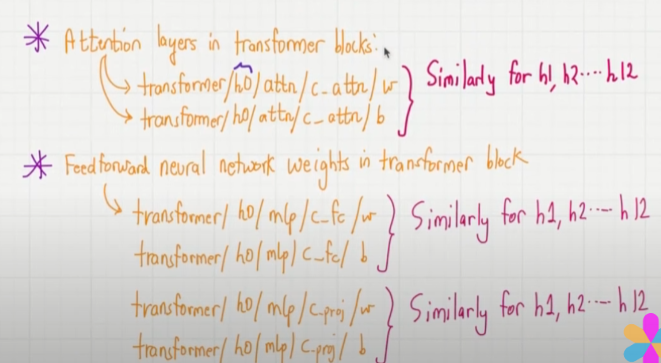

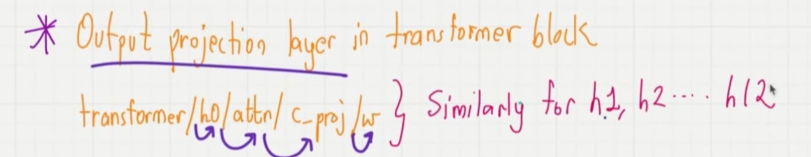

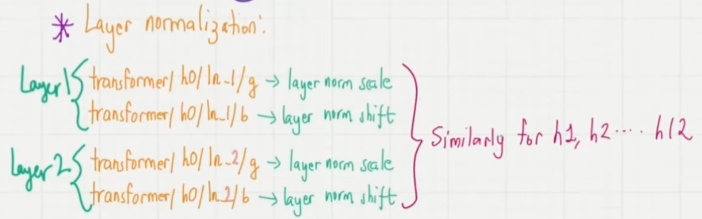

h0, h1, ..., h11 (h0 for first of the 12 transformer block)

attn (for attention mechanism part of transformer)

c_attn : fused weight matrix of Q, K, V

w : weight

b : bias

c_fc : for weights and biases of fully connected layer of feed forward network

c_proj : for weights and biases of projection layer (this is the projection layer of feed forward network)



Loading the dictionaries

In [8]:
print(settings.keys())
print(params.keys())

dict_keys(['n_vocab', 'n_ctx', 'n_embd', 'n_head', 'n_layer'])
dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [9]:
print(params["blocks"][0].keys())

print(params["blocks"][0]["attn"].keys())

dict_keys(['attn', 'ln_1', 'ln_2', 'mlp'])
dict_keys(['c_attn', 'c_proj'])


In [10]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


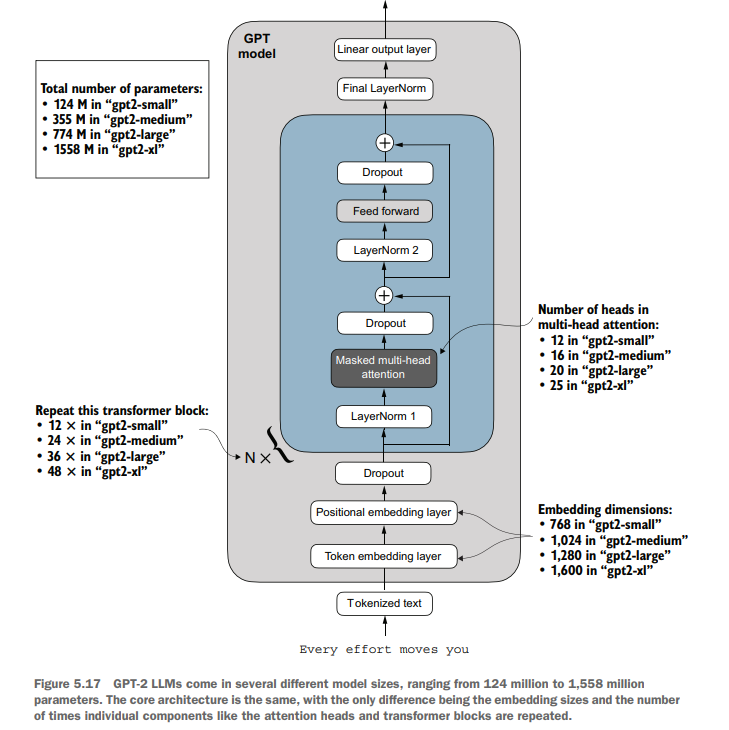

In [11]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}


GPT_CONFIG_124M = {
 "vocab_size": 50257, # Vocabulary size
 "context_length": 256, # Context length # We shorten the context length from 1024 to 256 for faster training
 "emb_dim": 768, # Embedding dimension
 "n_heads": 12, # Number of attention heads
 "n_layers": 12, # Number of layers
 "drop_rate": 0.1, # Dropout rate
 "qkv_bias": False # Query-Key-Value bias
}


model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 256,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

We used a 256-token length earlier, but the original GPT-2 models from OpenAI were trained with a 1,024-token length, so we have to update the NEW_CONFIG accordingly:


In [12]:
NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

OpenAI used bias vectors in the multi-head attention module’s linear layers to
implement the query, key, and value matrix computations. 

Bias vectors are **not commonly used** in LLMs anymore as they don’t improve the modeling performance and are thus unnecessary. 

However, since we are working with pretrained weights, we need to match the settings for consistency and enable these bias vectors:

In [13]:
NEW_CONFIG.update({"qkv_bias": True})
NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': True}

In [14]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()
print("Instance of GPTModel created")

Instance of GPTModel created


By default, the `GPTModel` instance is initialized with random weights for pretraining.
The last step to using OpenAI’s model weights is to override these random weights
with the weights we loaded into the `params` dictionary.

We first definne a small `assign` utility function that checks whether two tensors or arrays (left and right) have the same dimensions or shape and returns the right tensor as trainable PyTorch parameters:

In [15]:
# def assign(left, right):

#     if left.shape != right.shape:
#         raise ValueError(f"Shape mismatch. \nLeft: {left.shape}, Right: {right.shape}")
                           
#     return torch.nn.Parameter(torch.tensor(right))

In [16]:
import numpy as np
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [17]:
# import numpy as np

# def load_weights_into_gpt(gpt, params): 

#     # Assign the weights of the token and position embeddings that are directly accessible
#     # in the params dictionary to the gpt model

#     gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
#     gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

#     # Loop through each transformer block and assign the weights of the attention, feed forward
#     # network and layer normalization layers to the gpt model
#     for b in range(len(params["blocks"])): 

#         # Access the queries, keys and values weights of openai gpt2
#         # Since, the weights are stored in a single tensor, we need to split them
#         # into three tensors for queries, keys and values

#         q_w, k_w, v_w = np.split( 
#             (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)

#         gpt.trf_blocks[b].att.W_query.weight = assign(
#             gpt.trf_blocks[b].att.W_query.weight, q_w.T)

#         gpt.trf_blocks[b].att.W_key.weight = assign(
#             gpt.trf_blocks[b].att.W_key.weight, k_w.T)

#         gpt.trf_blocks[b].att.W_value.weight = assign(
#             gpt.trf_blocks[b].att.W_value.weight, v_w.T)

#         # Similarly for the bias values of the queries, keys and values
#         # We need to split the bias weights into three tensors for queries, keys and values
#         q_b, k_b, v_b = np.split(
#             (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)

#         gpt.trf_blocks[b].att.W_query.bias = assign(
#             gpt.trf_blocks[b].att.W_query.bias, q_b)

#         gpt.trf_blocks[b].att.W_key.bias = assign(
#             gpt.trf_blocks[b].att.W_key.bias, k_b)

#         gpt.trf_blocks[b].att.W_value.bias = assign(
#             gpt.trf_blocks[b].att.W_value.bias, v_b)

#         # The output projection weights 
#         gpt.trf_blocks[b].att.out_proj.weight = assign(
#             gpt.trf_blocks[b].att.out_proj.weight, 
#             params["blocks"][b]["attn"]["c_proj"]["w"].T)

#         # and output projection bias weights
#         gpt.trf_blocks[b].att.out_proj.bias = assign(
#             gpt.trf_blocks[b].att.out_proj.bias, 
#             params["blocks"][b]["attn"]["c_proj"]["b"])

#         # Feed forward network weights
#         # The weights of first layer of the feed forward network
#         gpt.trf_blocks[b].ff.layers[0].weight = assign(
#             gpt.trf_blocks[b].ff.layers[0].weight, 
#             params["blocks"][b]["mlp"]["c_fc"]["w"].T)

#         # The bias weights of first hidden layer (fc) of the feed forward network
#         gpt.trf_blocks[b].ff.layers[0].bias = assign(
#             gpt.trf_blocks[b].ff.layers[0].bias, 
#             params["blocks"][b]["mlp"]["c_fc"]["b"])

#         # The weights of output/projection layer of the feed forward network
#         gpt.trf_blocks[b].ff.layers[2].weight = assign(
#             gpt.trf_blocks[b].ff.layers[2].weight, 
#             params["blocks"][b]["mlp"]["c_proj"]["w"].T)

#         # The bias weights of output/projection layer of the feed forward network
#         gpt.trf_blocks[b].ff.layers[2].bias = assign(
#             gpt.trf_blocks[b].ff.layers[2].bias, 
#             params["blocks"][b]["mlp"]["c_proj"]["b"])

#         # Layer normalization scale and shift weights and biases for 2 layer norm layers
#         gpt.trf_blocks[b].norm1.scale = assign(
#             gpt.trf_blocks[b].norm1.scale, 
#             params["blocks"][b]["ln_1"]["g"])

#         gpt.trf_blocks[b].norm1.shift = assign(
#             gpt.trf_blocks[b].norm1.shift, 
#             params["blocks"][b]["ln_1"]["b"])

#         gpt.trf_blocks[b].norm2.scale = assign(
#             gpt.trf_blocks[b].norm2.scale, 
#             params["blocks"][b]["ln_2"]["g"])

#         gpt.trf_blocks[b].norm2.shift = assign(
#             gpt.trf_blocks[b].norm2.shift, 
#             params["blocks"][b]["ln_2"]["b"])

#     # The final layer normalization scale and shift weights and biases (outside the transformer block)
#     gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
#     gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])

#     # The final output projection weights is the same as the token embedding weights (weight tying)
#     gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [18]:
load_weights_into_gpt(gpt, params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

Now, let's use the openai loaded weights to generate text

In [19]:
from utils.generator import generate, generate_text_simple
from utils.conversion import text_to_token_ids, token_ids_to_text

In [20]:
import tiktoken

In [26]:
torch.manual_seed(23)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))




Output text:
 Every effort moves you forward to reach the top." And that's an excellent message. So it's about getting ahead. Those aren't things you


In [22]:
token_ids = generate_text_simple(
    model= gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you forward.

The first step is to understand the importance of your work.

The second step is to understand the


In [23]:
print(gpt.trf_blocks[10].att.W_value.bias)
print(gpt.trf_blocks[10].att.W_value.bias.shape)

Parameter containing:
tensor([ 4.5798e-02,  1.0085e-02, -6.0886e-03, -3.0355e-02, -2.7003e-02,
         1.7869e-02,  5.1345e-03,  1.4446e-02,  1.1581e-02, -1.5810e-02,
        -2.1820e-02,  2.7610e-02,  1.4784e-02, -1.0088e-02, -9.3569e-03,
        -5.0175e-02, -1.0512e-02,  1.0001e-03, -1.5922e-02,  1.9860e-02,
         9.4839e-03, -1.3754e-02,  3.8414e-03, -3.7336e-02, -2.9785e-02,
        -7.1754e-02,  2.8448e-02, -1.5905e-02, -8.3778e-03,  1.1444e-02,
         1.1405e-02, -6.1105e-02,  3.8464e-02,  2.3750e-02, -6.6197e-04,
        -1.8863e-02,  5.0408e-02,  5.0756e-03,  1.1328e-02,  1.3183e-02,
         2.5690e-02,  7.4207e-03,  1.1620e-02, -3.2392e-02,  1.8230e-02,
        -2.0266e-02,  1.2152e-02, -3.0828e-02,  4.6270e-03, -3.1944e-03,
         5.2460e-02,  1.4572e-02,  1.7572e-02, -5.2796e-02,  2.9113e-02,
         7.1282e-02, -6.4426e-02, -2.6170e-02, -1.0115e-01,  3.7290e-02,
         3.2871e-03,  2.0322e-02, -3.6829e-02, -8.1921e-03,  9.1080e-03,
        -3.3799e-03,  8.5576e

In [24]:
q_b, k_b, v_b = np.split(
            (params["blocks"][10]["attn"]["c_attn"])["b"], 3, axis=-1)


print(v_b)

[ 4.57983725e-02  1.00847967e-02 -6.08857209e-03 -3.03548332e-02
 -2.70025674e-02  1.78692285e-02  5.13448939e-03  1.44464122e-02
  1.15810502e-02 -1.58101656e-02 -2.18201131e-02  2.76100840e-02
  1.47841815e-02 -1.00877704e-02 -9.35685728e-03 -5.01752533e-02
 -1.05119180e-02  1.00012636e-03 -1.59224886e-02  1.98604036e-02
  9.48394742e-03 -1.37544740e-02  3.84136732e-03 -3.73355895e-02
 -2.97852084e-02 -7.17539117e-02  2.84483153e-02 -1.59048662e-02
 -8.37776810e-03  1.14441868e-02  1.14047201e-02 -6.11052290e-02
  3.84643748e-02  2.37497445e-02 -6.61966100e-04 -1.88625772e-02
  5.04079908e-02  5.07559394e-03  1.13284383e-02  1.31827341e-02
  2.56901141e-02  7.42067443e-03  1.16196582e-02 -3.23924907e-02
  1.82303768e-02 -2.02657003e-02  1.21523486e-02 -3.08279581e-02
  4.62703174e-03 -3.19436332e-03  5.24603836e-02  1.45721836e-02
  1.75721347e-02 -5.27961776e-02  2.91134790e-02  7.12822750e-02
 -6.44256845e-02 -2.61701439e-02 -1.01145469e-01  3.72895822e-02
  3.28705064e-03  2.03223

In [25]:
idx = text_to_token_ids("Every effort moves you", tokenizer).to(device)
with torch.no_grad():
    logits = gpt(idx)
print("Logits shape:", logits.shape)  # Expected: [1, seq_len, 50257]
last_logits = logits[:, -1, :]
top_tokens = torch.topk(last_logits, k=5, dim=-1).indices
print("Top 5 predicted tokens:", [tokenizer.decode([t.item()]) for t in top_tokens[0]])

Logits shape: torch.Size([1, 4, 50257])
Top 5 predicted tokens: [' forward', ' to', ' along', '.', ',']
